In [1]:
import sys; sys.path.insert(0, '../../external/')

import ira
%alphalab

from alpha.utils.data_helpers import FriendlyFxLoader

Reloaded ../../external/ira/experimental/c_simulator_core.pyx


In [2]:
from ira.analysis.portfolio import split_cumulative_pnl
from ira.charting.plot_helpers import subplot
from ira.simulator import SignalTester, GenericStockBrokerInfo, GenericCryptoFuturesBrokerInfo, GenericCryptoBrokerInfo, \
    GenericForexBrokerInfo
from ira.simulator.SignalTester import Tracker
from ira.simulator.optimizer_proxy import run_optimizer
from ira.simulator.tester_proxy import run_test
from ira.utils.nb_functions import _progress_bar

In [88]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlc('EURUSD')[:10000]

s = srows(
    pd.Series(1, data[data.close > data.close.shift(12)].index),
    pd.Series(-1, data[data.close < data.close.shift(12)].index)).sort_index().rename('EURUSD')

In [4]:
def __instantiate_simulated_broker(broker, spread: Union[dict, float]):
    if isinstance(broker, str):
        # for general brokers we require implicit spreads here
        if spread is None:
            raise ValueError("Spread policy must be specified ! You need pass either fixed spread or dictionary")

        brk_ctor = {
            'stock': lambda: GenericStockBrokerInfo(spread=spread),
            'forex': lambda: GenericForexBrokerInfo(spread=spread),
            'crypto': lambda: GenericCryptoBrokerInfo(spread=spread),
            'crypto_futures': lambda: GenericCryptoFuturesBrokerInfo(spread=spread),
        }.get(broker)

        if brk_ctor is None:
            raise ValueError("Unknown broker type '%s'" % broker)

        broker = brk_ctor()
    return broker

def run_test(signals, datasource, broker, spread=None, tracker=None, **kwargs):
    if isinstance(datasource, (pd.DataFrame, dict)):
        # not needed to import this class to notebook
        from ira.datasource.InMemoryDataSource import InMemoryDataSource
        datasource = InMemoryDataSource(datasource)

    tester = SignalTester(__instantiate_simulated_broker(broker, spread), datasource)
    pm_logger = tester.run_signals(signals, jupyter_progress_listener=_progress_bar(), tracker=tracker, **kwargs)
    return split_cumulative_pnl(pm_logger.get_portfolio_log())

In [5]:
class FixTracker(Tracker):
    
    def track(self, position: Position, instrument: str, time, signal, quote_time, bid, ask, bid_size, ask_size):
        return -signal * 10000

In [ ]:
p = run_test(shift_signals(s, minutes=4), {'EURUSD': data}, 'forex', spread=fxl.spread('EURUSD'), tracker=FixTracker(), verbose=False)

Statistic,Model
Gain (USD):,363.56
CAGR (%):,377.466
Sharpe:,3.694
Sortino:,7.007
Calmar:,42.915
MaxDD (%):,13.138
MaxDD On Init BP (%):,17.955
MaxDD (USD):,179.553
MaxDD days:,12 days
MaxDD start:,2014-02-07

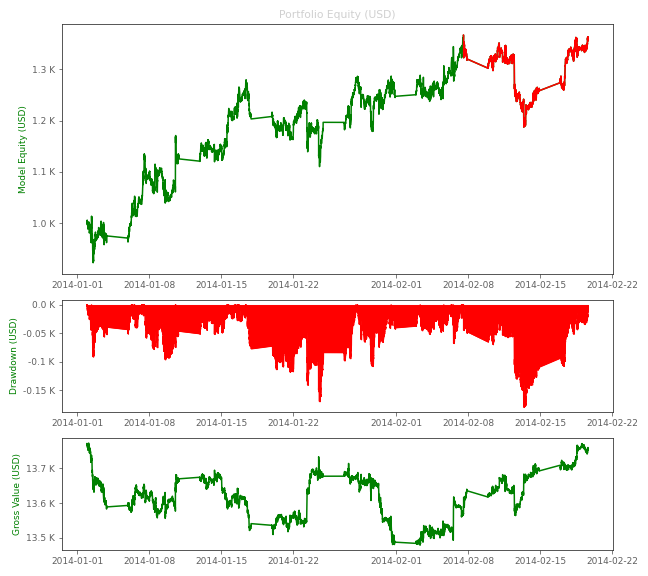

<Figure size 648x576 with 0 Axes>

In [10]:
tearsheet(p, 1000)

<hr/>

In [163]:
A = np.array([[1,3,4, -1, -2, -3], [11,22,33, -11,-22,-33]])

In [186]:
from datetime import timedelta
pd.Timedelta(timedelta(hours=9, minutes=30, seconds=1))

Timedelta('0 days 09:30:01')

In [180]:
%%timeit

a,b,av,bv,f = A[0, np.array([0,1,2,1,1]) + 3]
# a,b,av,bv,f = A[0, [0,1,2,1,1]]

4.18 µs ± 76.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [174]:
a,b,av,bv,f

(-1, -2, -3, -1, -1)

In [ ]:
pd.set_option('display.max')

In [14]:
pd.DateOffset(milliseconds=1)

<DateOffset>

In [17]:
pd.Timedelta(0)

Timedelta('0 days 00:00:00')

In [38]:
shift_signals(pd.Series([1,2,4], pd.date_range('2020-01', periods=3)), '100Ms', hours=1)

2020-01-01 01:00:00.100    1
2020-01-02 01:00:00.100    2
2020-01-03 01:00:00.100    4
dtype: int64

In [122]:
from ira.analysis.timeseries import infer_series_frequency

ohlc = data
freq = pd.Timedelta(infer_series_frequency(data))
before_close = freq - freq/5
in_middle1 = freq/2 + freq/10
in_middle2 = freq/2 - freq/10
half_spread = 1e-6

In [123]:
before_close, in_middle1, in_middle2

(Timedelta('0 days 00:04:00'),
 Timedelta('0 days 00:03:00'),
 Timedelta('0 days 00:02:00'))

In [124]:
z = ohlc.open.shift(1, freq=pd.Timedelta(0))
p1 = pd.DataFrame({'bid': z - half_spread, 'ask': z + half_spread, 'bidvol': 1e12, 'askvol': 1e12,
                   'is_real': True})

z = ohlc.close.shift(1, freq=before_close)
p2 = pd.DataFrame({'bid': z - half_spread, 'ask': z + half_spread, 'bidvol': 1e12, 'askvol': 1e12, 
                   'is_real': True})

z = ohlc.low.shift(1, freq=in_middle1)
p3 = pd.DataFrame({'bid': z - half_spread, 'ask': z + half_spread, 
                   'is_real': False})

z = ohlc.high.shift(1, freq=in_middle2)
p4 = pd.DataFrame({'bid': z - half_spread, 'ask': z + half_spread,
                   'is_real': False})

# ticks = srows(p1, p2, p3, p4)
ticks = pd.concat((p1, p2, p3, p4), axis=0).sort_index()

In [141]:
ticks.filter(items=['ask', 'WTF1'])

,ask
time,
2014-01-01 22:00:00,1.375951
2014-01-01 22:02:00,1.376031
2014-01-01 22:03:00,1.375391
2014-01-01 22:04:00,1.375431
2014-01-01 22:05:00,1.375431
...,...
2020-11-26 23:54:00,1.191196
2020-11-26 23:55:00,1.191211
2020-11-26 23:57:00,1.191221


In [145]:
from qlearn.core.data_utils import make_dataframe_from_dict
make_dataframe_from_dict(data, 'ohlc')

,open,high,low,close,volume
time,,,,,
2014-01-01 22:00:00,1.375950,1.376030,1.375390,1.375430,38
2014-01-01 22:05:00,1.375430,1.376260,1.375385,1.375685,27
2014-01-01 22:10:00,1.375605,1.375800,1.374065,1.375365,106
2014-01-01 22:15:00,1.375250,1.375525,1.375025,1.375445,38
2014-01-01 22:20:00,1.375455,1.376330,1.375395,1.376235,29
...,...,...,...,...,...
2020-11-26 23:35:00,1.191010,1.191045,1.190955,1.190960,62
2020-11-26 23:40:00,1.190965,1.191055,1.190960,1.190995,38
2020-11-26 23:45:00,1.191000,1.191055,1.191000,1.191045,40


In [129]:
(ohlc_resample(ticks, '5Min') - ohlc).sum()

close     0.0
high      0.0
low       0.0
open      0.0
volume    0.0
dtype: float64

In [ ]:
srows(p1, p2, p3, p4)

In [181]:
with DataSource('databank::quotes', overload_props={'api_url':'http://venus.appliedalpha.com:8881/v1/'}) as ds:
    d = ds.load_data('fpmarkets:EURUSD', '2021-01-14 10:00:00', '2021-01-14 10:30:00')

In [ ]:
d